# [문제 1] Fashion MNIST 데이터 정규화를 위한 Mean과 Std. 값 찾기

In [1]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn,optim

from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

BASE_PATH=str(Path('/content/drive/MyDrive/link_dl').resolve())
print(BASE_PATH)

import sys
sys.path.append(BASE_PATH)

from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows

/content/drive/MyDrive/link_dl


####**mean과 std. 값 찾기**

In [2]:
data_path=os.path.join(BASE_PATH,"_00_data","j_fashion_mnist")
f_mnist_train=datasets.FashionMNIST(data_path,train=True,transform=transforms.ToTensor())
f_mnist_train,f_mnist_validation=random_split(f_mnist_train,[55000,5000])
img_t,_=f_mnist_train[0]
imgs=torch.stack([img_t for img_t,_ in f_mnist_train],dim=3)
print(imgs.view(1,-1).mean(dim=-1))
print(imgs.view(1,-1).std(dim=-1))

tensor([0.2861])
tensor([0.3531])


####따라서 mean은 0.2861 std는 0.3531로 수정하여 데이터를 정규화 하는 것이 좋다.

# [문제 2] Fashion MNIST 데이터에 대하여 CNN 학습시키기

In [3]:
def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    train_transforms = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=train_transforms)
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55000, 5000])

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Data Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])
    print("Sample Data Target: ", f_mnist_train[0][1])  # 9

    num_data_loading_workers = get_num_cpu_cores()
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2861, std=0.3531),
    )

    return train_data_loader, validation_data_loader, f_mnist_transforms

In [4]:
def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2861, std=0.3531),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

In [5]:
!pip install wandb

In [6]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ajb020506 (ajb020506-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
from datetime import datetime
from _01_code._09_fcn_best_practice.c_trainer import ClassificationTrainer

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(BASE_PATH))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))


def get_cnn_model():
    class MyModel(nn.Module):
        def __init__(self, in_channels, n_output):
            super().__init__()

            self.features = nn.Sequential(
                # 출력 크기 조정: 28x28 to 14x14
                nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(0.25),

                # 출력 크기 조정: 14x14 to 7x7
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(0.3),

                #  출력 크기 조정: 7x7 to 3x3
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(0.4),
            )

            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(256 * 3 * 3, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, n_output),
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    my_model = MyModel(in_channels=1, n_output=10)
    return my_model

In [ ]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "fashion_mnist_cnn"
  wandb.init(
    mode="online",
    project=project_name,
    notes="fashion mnist experiment with cnn",
    tags=["cnn", "fashion mnist"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()
  model = get_cnn_model()
  model.to(device)

  from torchinfo import summary
  summary(model=model, input_size=(1, 1, 28, 28))

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate,weight_decay=wandb.config.weight_decay)


  classification_trainer = ClassificationTrainer(
     project_name, model, optimizer, train_data_loader, validation_data_loader, mnist_transforms,
     run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()

if __name__ == "__main__":
   parser=get_parser()
   args=parser.parse_args()
   main(args)

기본적인 cnn 모델로는 validation accuuracy가 92점에서 머무르는 것을 확인하여 여러 하이퍼 파라미터를 수정하였지만 눈에 띄는 성과를 얻지는 못 했다.  그래서 모델을 더 복잡하게 수정했다.

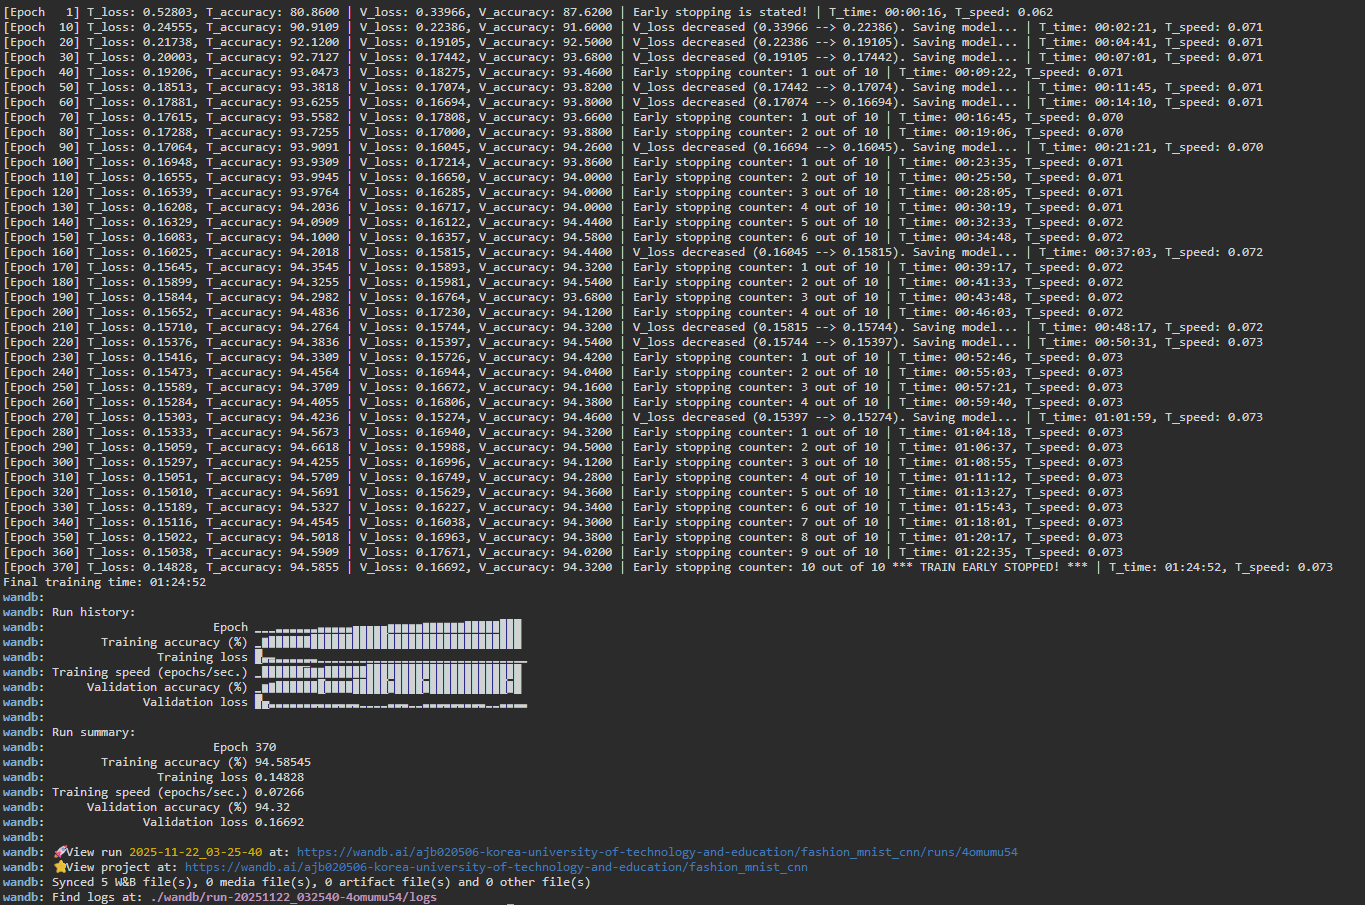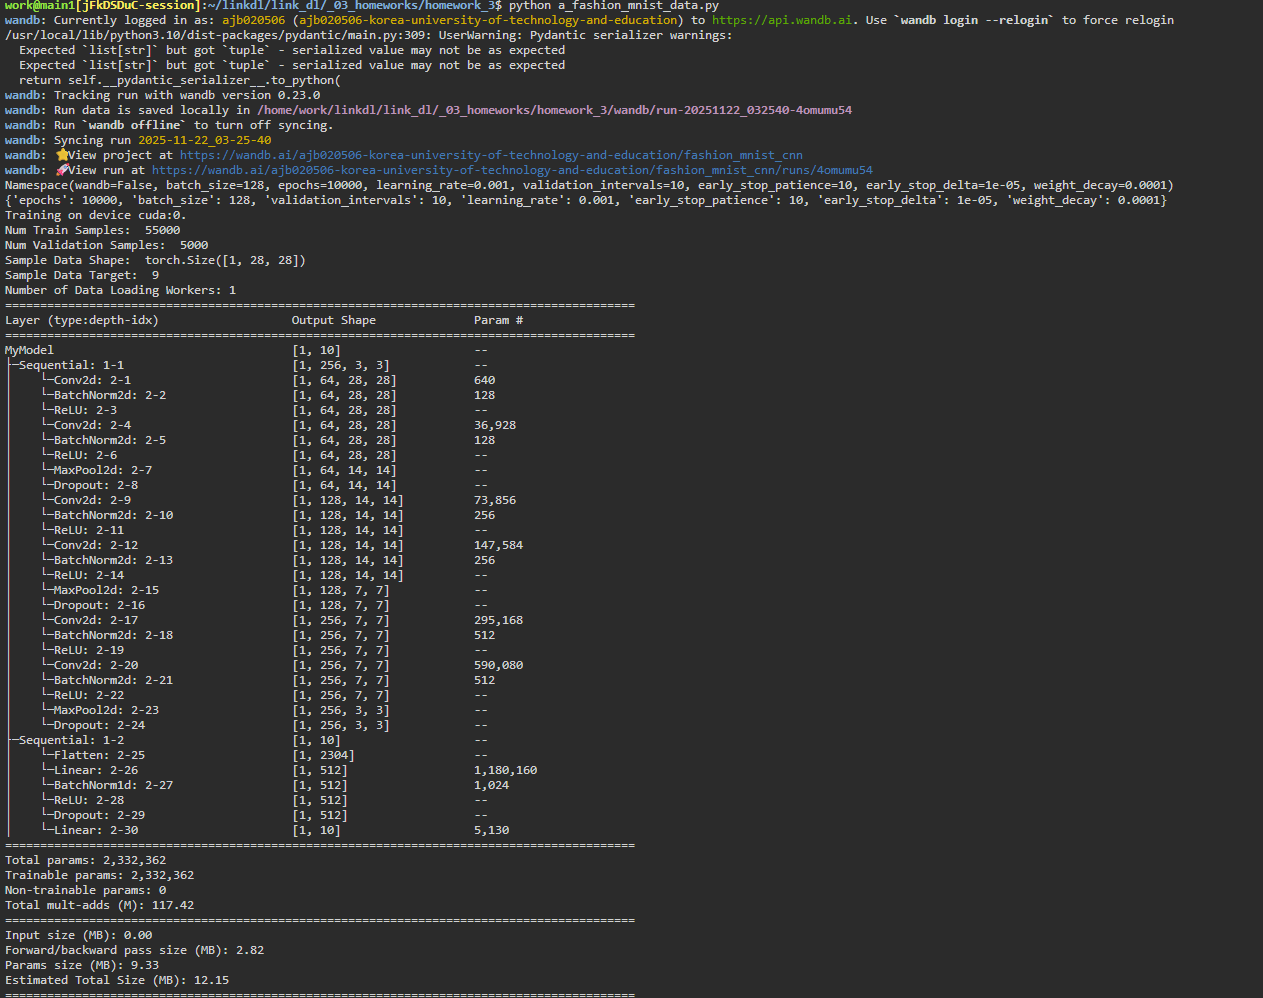

# [문제 3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기 & [문제 4] 샘플 테스트 데이터 분류 예측 결과 확인하기

In [ ]:
LABELS_MAP = {
    0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'
}


def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.2861, std=0.3531)
    ])

    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=test_transforms)

    # 시각화를 위해 shuffle=False로 설정
    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=1000, shuffle=False)

    return test_data_loader, test_transforms, f_mnist_test


def get_cnn_model():
    class MyModel(nn.Module):
        def __init__(self, in_channels, n_output):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64), nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64), nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(0.25),

                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128), nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128), nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(0.3),

                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256), nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256), nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(0.4),
            )
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(256 * 3 * 3, 512),
                nn.BatchNorm1d(512), nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, n_output),
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    return MyModel(in_channels=1, n_output=10)

In [ ]:
def visualize_problem_4(model, test_loader, device):
    model.eval()

    correct_samples = []
    wrong_samples = []

    print(">>> Collecting predictions for visualization (Memory Optimized)...")

    # 메모리 초과 방지를 위해 각각 최대 20개까지만 수집
    MAX_COLLECT = 20

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            pred_labels = torch.argmax(outputs, dim=1)

            for i in range(len(labels)):
                # 이미 충분히 모았으면 루프 탈출
                if len(correct_samples) >= MAX_COLLECT and len(wrong_samples) >= MAX_COLLECT:
                    break

                img = images[i].cpu()
                lbl = labels[i].item()
                pred = pred_labels[i].item()

                if lbl == pred:
                    if len(correct_samples) < MAX_COLLECT:
                        correct_samples.append((img, lbl, pred))
                else:
                    if len(wrong_samples) < MAX_COLLECT:
                        wrong_samples.append((img, lbl, pred))

            if len(correct_samples) >= MAX_COLLECT and len(wrong_samples) >= MAX_COLLECT:
                print("   -> Collected enough samples. Stopping loop.")
                break


    selected_samples = []

    if len(wrong_samples) > 0:
        selected_samples.append(random.choice(wrong_samples))
        needed_random = 9
    else:
        needed_random = 10

    all_remaining = correct_samples + wrong_samples
    count_to_pick = min(len(all_remaining), needed_random)

    selected_samples.extend(random.sample(all_remaining, count_to_pick))
    random.shuffle(selected_samples)

    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f"[Problem 4] Prediction Visualization", fontsize=16)

    print("\n" + "=" * 60)
    print(f"{'Idx':<5} {'True Label':<20} {'Prediction':<20} {'Result'}")
    print("=" * 60)

    for idx, (img_tensor, label, pred) in enumerate(selected_samples):
        img_np = img_tensor.squeeze().numpy()

        is_correct = (label == pred)
        result_str = "CORRECT" if is_correct else "WRONG  <--"
        color = 'blue' if is_correct else 'red'

        label_name = LABELS_MAP[label]
        pred_name = LABELS_MAP[pred]

        print(f"{idx + 1:<5} {label_name:<20} {pred_name:<20} {result_str}")

        ax = fig.add_subplot(2, 5, idx + 1)
        ax.imshow(img_np, cmap='gray')
        ax.set_title(f"L: {label_name}\nP: {pred_name}", color=color, fontsize=10)
        ax.axis('off')

    print("=" * 60)
    plt.tight_layout()
    plt.show()

In [ ]:
def main():
    project_name = "fashion_mnist_cnn"
    device = torch.device("cpu")
    test_data_loader, test_transforms, _ = get_fashion_mnist_test_data()
    model = get_cnn_model().to(device)

    print(f">>> Checking Model in: {CHECKPOINT_FILE_PATH}")

    no_transform = transforms.Compose([])

    classification_tester = ClassificationTester(
        project_name,
        model,
        test_data_loader,
        no_transform,
        CHECKPOINT_FILE_PATH
    )


    classification_tester.test()


    print("\n" + "#" * 50)
    print(" STARTING PROBLEM 4: VISUALIZATION & ANALYSIS ")
    print("#" * 50)
    visualize_problem_4(model, test_data_loader, device)


if __name__ == "__main__":
    main()
    main()

스크린샷 2025-11-22 224404.png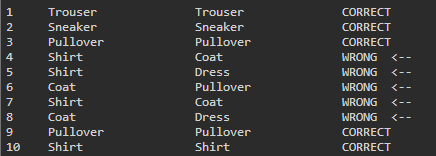

형태가 비슷하거나 너무 섬세한 부분은 아직 모델이 제대로 학습이 되지 못 한 것같다. 예를 들어서 Shirt 와 Coat는 모두 긴 소매를 가지고 있고,  앞부분이 단추나 지퍼로 덮어져 있는 부분이 모델이 구분하기에 어렵게 느껴질 수 있다고 생각한다. 또한 여러 경우를 테스트 해보았을 때 Ankle Boot와 Sneaker를 구분하지 못 하는 경우를 보았는데 형태가 비슷하기 때문에 아직 모델이 정확히 분류하지 못 했다고 생각한다.

# 숙제후기

이번 과제를 수행하면서 여러 하이퍼 파라미터가 모델 학습에 영향을 줄 수 있다는 것을 알게 되었다. 하지만 하이퍼 파라미터보다 더 중요하다고 생각이 든 것은 결국에는 모델이 중요하다고 생각이 들었다. 처음에 cnn 모델에 있는 하이퍼 파라미터만으로도 수정을 통해 충분히 validation accuracy를 높일수 있다고 생각했지만 각 데이터에 맞는 모델혹은 augment 등 여러가지 요소가 전부 중요하다는 것을 깨닫게 되었다.